# Experiment 1-A

This experiment used the full corpus of 6K+ texts scraped from JSTOR.

In [36]:
import pandas as pd
%matplotlib inline
from ast import literal_eval
import numpy as np
import re
import json
from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]

In [2]:
with open('txt/e1a.json') as f: 
    rawData = f.read()

In [3]:
df = pd.read_json(rawData)

In [4]:
df['Decade'] = df['year'] - (df['year'] % 10)

In [5]:
df.head()

,author,coverdate,disc_name,doi,id,jcode,journal,la,matches,no,...,pages,publisher_name,sp,srcHtml,title,topics,ty,vo,year,Decade
0,[Harriet Farwell Adams],[19840601],"[Language & Literature, Humanities]",10.2307/3044822,c6e6ce20-79c4-3c59-af91-b06c3208b37b,[ninecentfict],Nineteenth-Century Fiction,[eng],"[23, [[5809, 6218], [8751, 8851], [8890, 9046]...",[1],...,69-90,[University of California Press],69,"<cite>Nineteenth-Century Fiction</cite>, Vol. ...","[Dorothea and ""Miss Brooke"" in Middlemarch]","[Sentiment, Fear, Martyrdom, Envy, Vocation, G...",fla,[39],1984,1980
1,[HUGH WITEMEYER],[19910901],"[Language & Literature, Humanities]",10.2307/43470798,0d7eb58a-e4c1-326b-a195-012da1a4eb11,[georelioghlnews],"The George Eliot, George Henry Lewes Newsletter",[eng],"[0, [], []]",[18/19],...,73-78,[Penn State University Press],73,"<cite>The George Eliot, George Henry Lewes New...",NaN,"[Lecture methods, Feminism, Pedagogy, Novelist...",brv,NaN,1991,1990
2,"[Alison Cree, Louis J. Guillette, <suffix>Jr.<...",[19950601],"[Biological Sciences, Science and Mathematics,...",10.2307/1564553,f7384b7a-36be-3f0f-ac0b-b66455da0d36,[jherpetology],NaN,[eng],"[0, [], []]",[2],...,163-173,[Society for the Study of Amphibians and Repti...,163,"<cite>Journal of Herpetology</cite>, Vol. 29, ...",[Biennial Reproduction with a Fourteen-Month P...,"[Animal vivipary, Parturition, Fat body, Skink...",fla,[29],1995,1990
3,[Calvin Bedient],[19690401],"[Language & Literature, Humanities]",10.2307/3849222,ba20b1ad-b273-3608-bc9b-17b13f6d4e68,[hudsonreview],The Hudson Review,[eng],"[2, [[1820, 1922], [1787715, 1787883]], [[2324...",[1],...,70-84,"[Hudson Review, Inc]",70,"<cite>The Hudson Review</cite>, Vol. 22, No. 1...",[Middlemarch: Touching Down],"[Immortality, Asceticism, Sentimentality, Mete...",fla,[22],1969,1960
4,[Jane S. Smith],[19770701],"[Language & Literature, Humanities]",10.2307/40754482,ef12c01b-c42d-39b8-84dd-d00e6538143c,[texastudlitelang],Texas Studies in Literature and Language,[eng],"[5, [[397716, 398239], [1588815, 1589172], [15...",[2],...,188-203,[University of Texas Press],188,<cite>Texas Studies in Literature and Language...,[The Reader as Part of the Fiction: Middlemarch],"[Novels, Flattery, Humor, Vanity, Meditation, ...",fla,[19],1977,1970


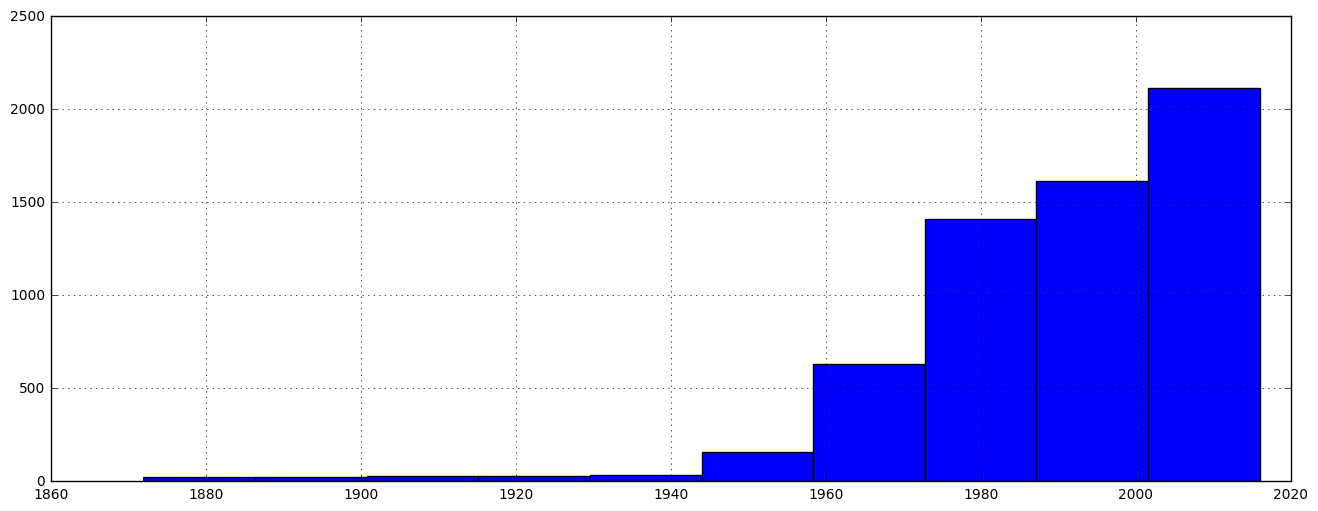

In [6]:
df['year'].hist()

In [7]:
textALength = 1793449

In [8]:
df['Locations in A'] = df['matches'].apply(lambda x: x[1])

In [227]:
def diachronicAnalysis(df, decades=(1950, 2020)): 
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locations = row['Locations in A']
        if decade not in decadeDict: 
            decadeDict[decade] = locations
        else: 
            decadeDict[decade] += locations 
    # Grab the beginnings of quotes. 
    decadeStarts = {decade: [item[0] for item in loc] for decade, loc in decadeDict.items()}
    decadesBinned = {decade: 
                 np.histogram(locations, bins=50, range=(0, textALength))[0]
                 for decade, locations in decadeStarts.items() if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def plotDiachronicAnalysis(decadesDF): 
    ylabels = [str(int(decade)) for decade in decadesDF.index] + ['2020']
    plt.pcolor(decadesDF, cmap='gnuplot')
    plt.yticks(np.arange(len(decadesDF.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Novel Segment')
    plt.title("Frequency of Quotations from George Eliot's Middlemarch in Criticism, By Decade")
    plt.colorbar(ticks=[])
    plt.show()
    
def plotSynchronicAnalysis(decadesDF): 
    ax = decadesDF.sum().plot(kind='bar')

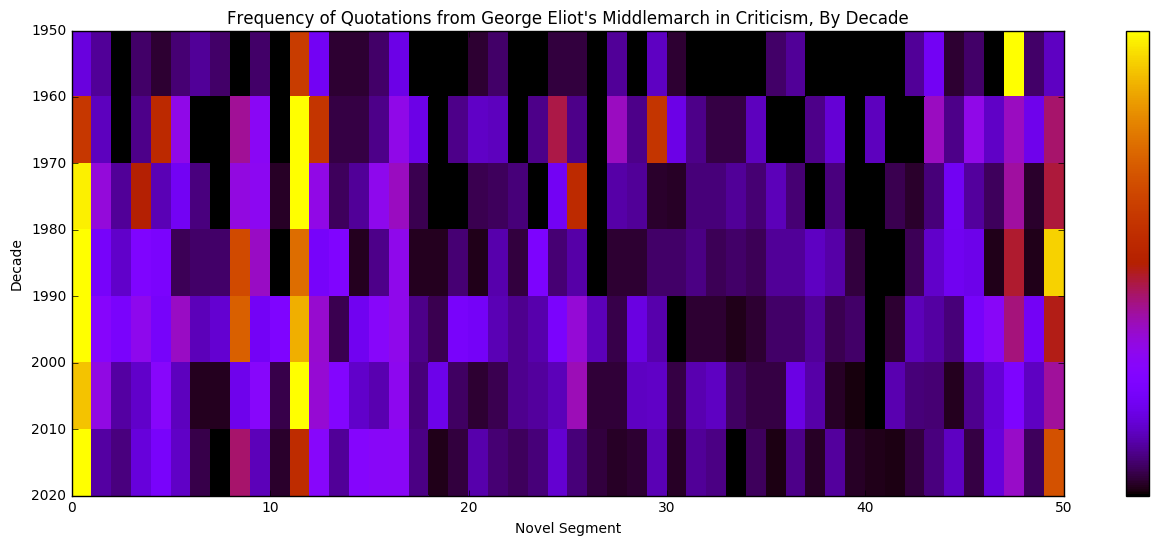

In [91]:
decadesDF = diachronicAnalysis(df)
plotDiachronicAnalysis(decadesDF)

# By (Guessed) Gender of Author

In [27]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

In [81]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [82]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

In [100]:
decadesDFM, decadesDFF = diachronicAnalysis(dfM), diachronicAnalysis(dfF)

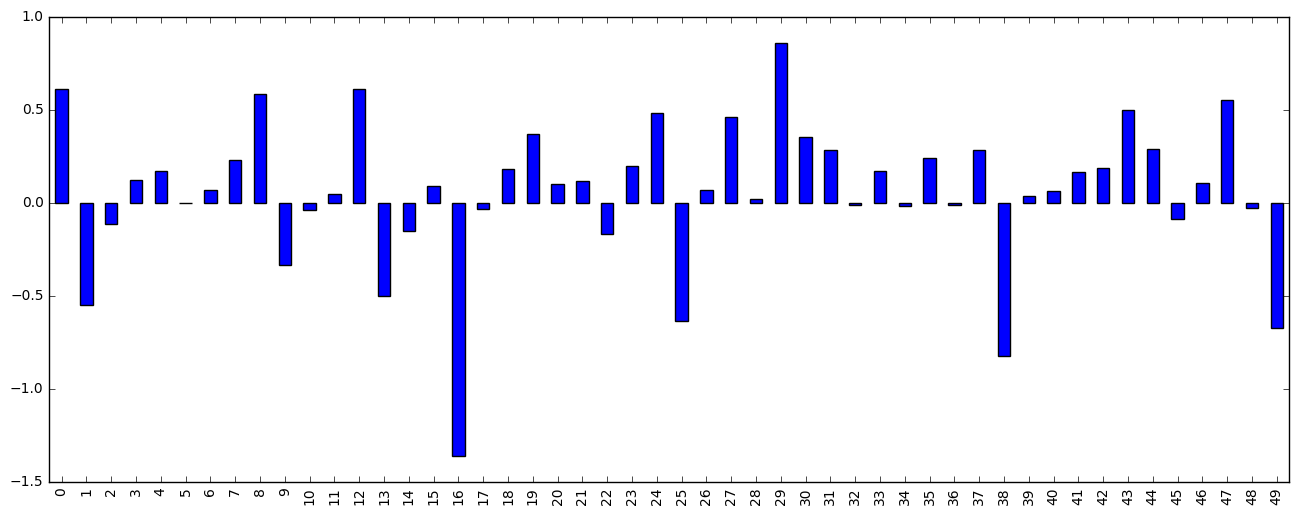

In [110]:
# Differences in citations between genders. 
decadesGenderDiff = decadesDFM - decadesDFF
plotSynchronicAnalysis(decadesGenderDiff)

# By (Guessed) Country of Publication

In [128]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [158]:
publishers = topPublishers[:80].index

In [159]:
publishers = publishers.tolist()

In [190]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [193]:
df['country'] = df['publisher_name'].apply(getCountry)

In [195]:
df['country'].value_counts()

US         3901
Unknown    1247
Britain     825
Canada       59
Germany      15
Ireland       8
Spain         8
France        6
Name: country, dtype: int64

In [200]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [201]:
decadesDFBrits, decadesDFYanks = diachronicAnalysis(dfBrits), diachronicAnalysis(dfYanks)

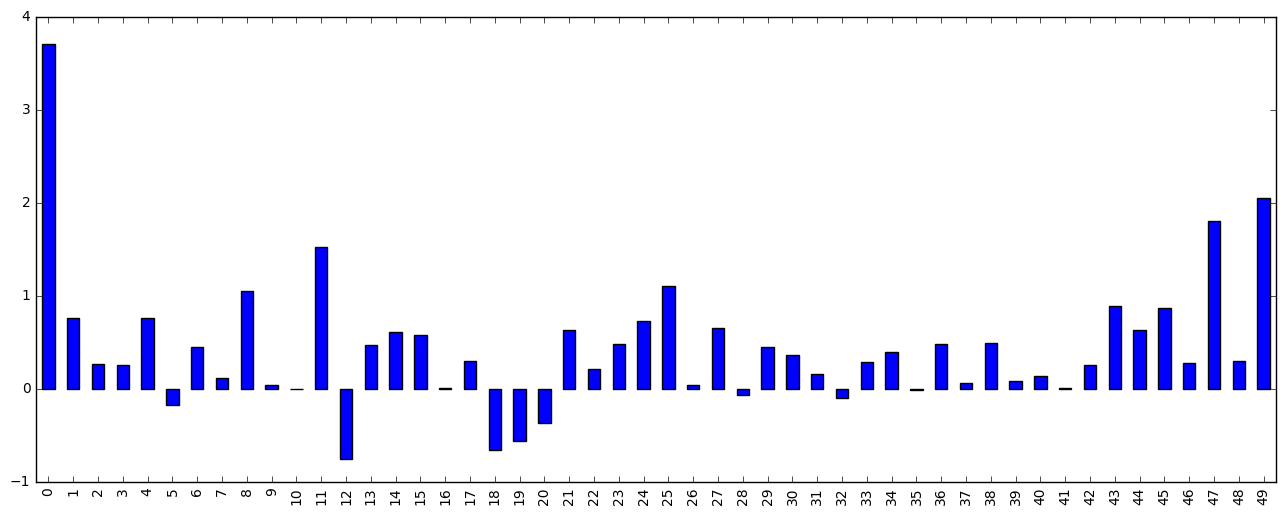

In [204]:
plotSynchronicAnalysis(decadesDFYanks-decadesDFBrits)

# By Journal

In [213]:
# Look at the top journals. 
df['journal'].value_counts()[:10]

Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
NOVEL: A Forum on Fiction                    126
Nineteenth-Century Literature                126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [211]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

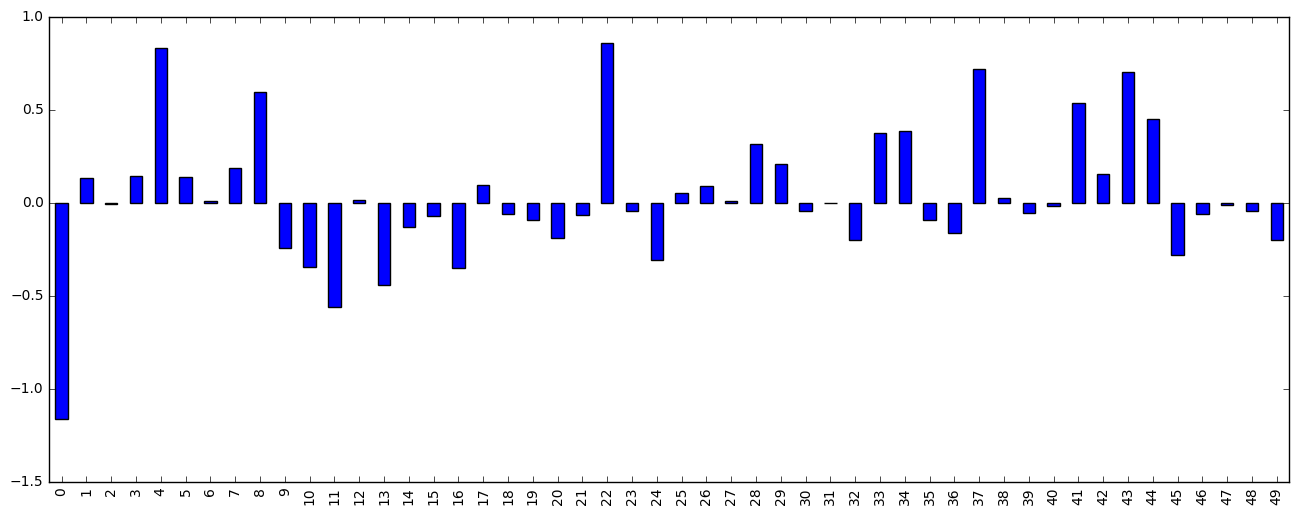

In [228]:
ax = plotSynchronicAnalysis(diachronicAnalysis(geJournals) - diachronicAnalysis(otherJournals))